In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from scipy import spatial
import operator



[nltk_data] Downloading package stopwords to /Users/yogee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
movies = pd.read_csv('./archive/tmdb_5000_movies.csv')
credits = pd.read_csv('./archive/tmdb_5000_credits.csv')

In [3]:
movies['genres'] = movies['genres'].apply(json.loads)
for index,i in zip(movies.index,movies['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    movies.loc[index,'genres'] = str(list1)
    

In [4]:
movies['keywords'] = movies['keywords'].apply(json.loads)
for index,i in zip(movies.index,movies['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    movies.loc[index,'keywords'] = str(list1)

In [5]:
movies['production_companies'] = movies['production_companies'].apply(json.loads)
for index,i in zip(movies.index,movies['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    movies.loc[index,'production_companies'] = str(list1)

In [6]:
credits['cast'] = credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    credits.loc[index,'cast'] = str(list1)

In [7]:
credits['crew'] = credits['crew'].apply(json.loads)
for index,i in zip(credits.index,credits['crew']):
    list1 = []
    for j in range(len(i)):
        if(i[j]['job'] == 'Director'):
            credits.loc[index,'director'] = str(i[j]['name'])

In [8]:
movies = movies.merge(credits, left_on='id', right_on='movie_id', how='left')


In [9]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'movie_id', 'title_y', 'cast', 'crew', 'director'],
      dtype='object')

In [10]:
movies = movies[['id', 'original_title', 'genres', 'cast', 'vote_average', 'keywords', 'director']]

We will clean the genre column to find the genre_list




In [11]:
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

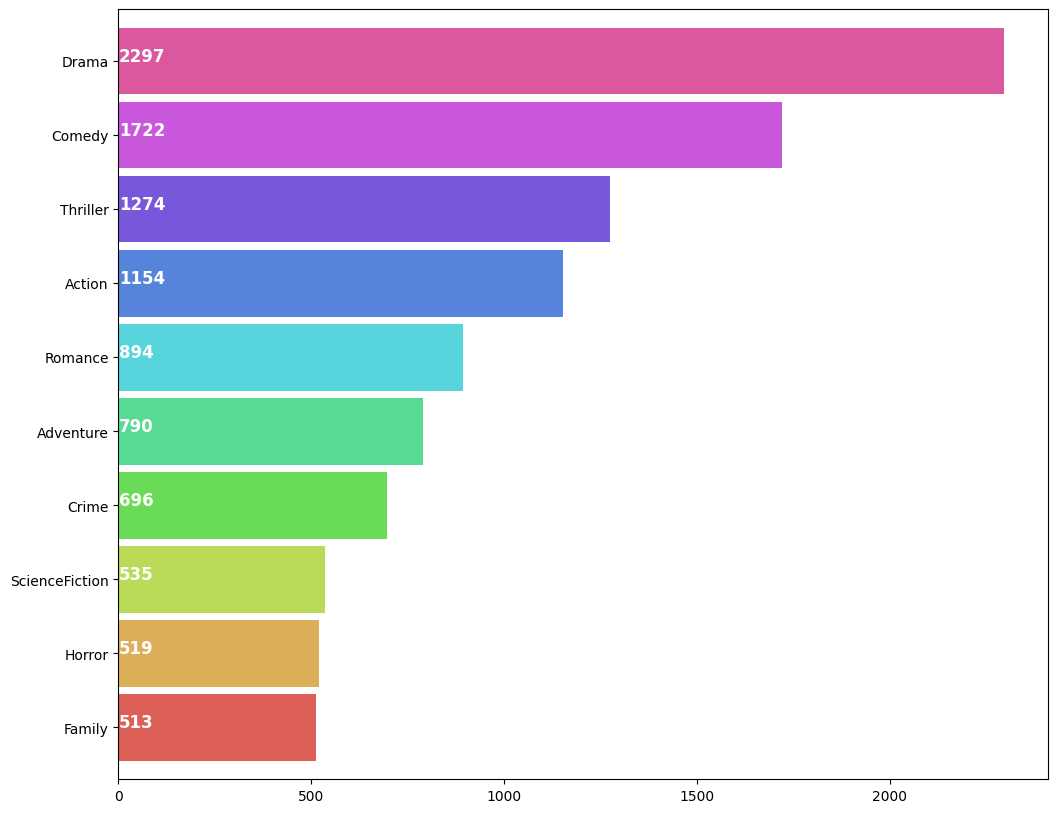

In [12]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.show()



Now let’s generate a list ‘genreList’ with all possible unique genres mentioned in the dataset.



In [13]:
genreList = []
for index, row in movies.iterrows():
    genres = row["genres"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #now we have a list with unique genres

['Action',
 'Adventure',
 'Fantasy',
 'ScienceFiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western']

Function to show if a movie belongs to a particular genre or not from binary list containing zeros and ones 

In [14]:
def binary(genre_list, genreList):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [15]:
movies['genres_bin'] = movies['genres'].apply(lambda x: binary(x, genreList))
movies['genres_bin'].head()


0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

In [16]:
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['cast'] = movies['cast'].str.split(',')

Working with the Cast column to display as plot based on highest appearanced actors on movies 

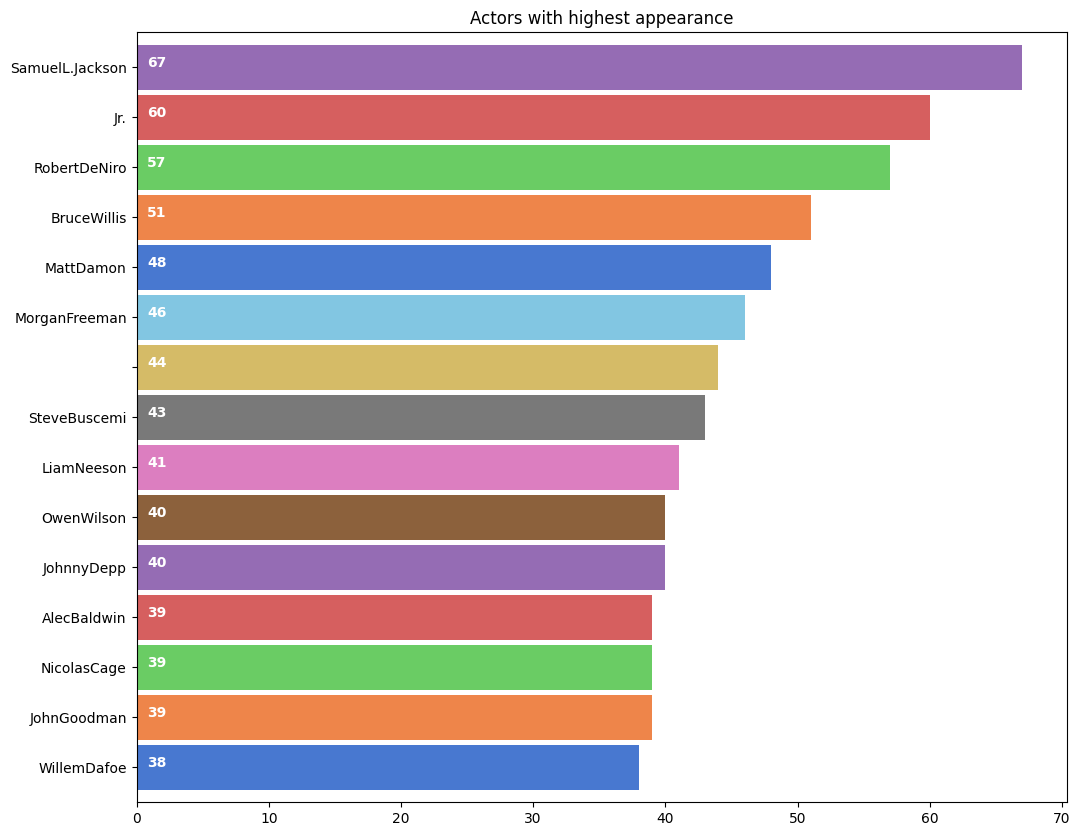

In [17]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

When I initially created the list of all the cast, it had around 50k unique values, as many movies have entries for about 15–20 actors. But do we need all of them? The answer is No. We just need the actors who have the highest contribution to the movie. For eg: The Dark Knight franchise has many actors involved in the movie. But we will select only the main actors like Christian Bale, Micheal Caine, Heath Ledger. I have selected the main 4 actors from each movie.



In [18]:
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i[:4]
    movies.loc[j,'cast'] = str(list2)
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['cast'] = movies['cast'].str.split(',')
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'cast'] = str(list2)
movies['cast']=movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
castList = []
for index, row in movies.iterrows():
    cast = row["cast"]
# convert a string of elements having seperated by comma to the list of elements
    for i in cast.split(','):
        if i not in castList:
            castList.append(i)
movies['cast_bin'] = movies['cast'].apply(lambda x: binary(x, castList))
movies['cast_bin'].head()

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: cast_bin, dtype: object

Working with the Directors column

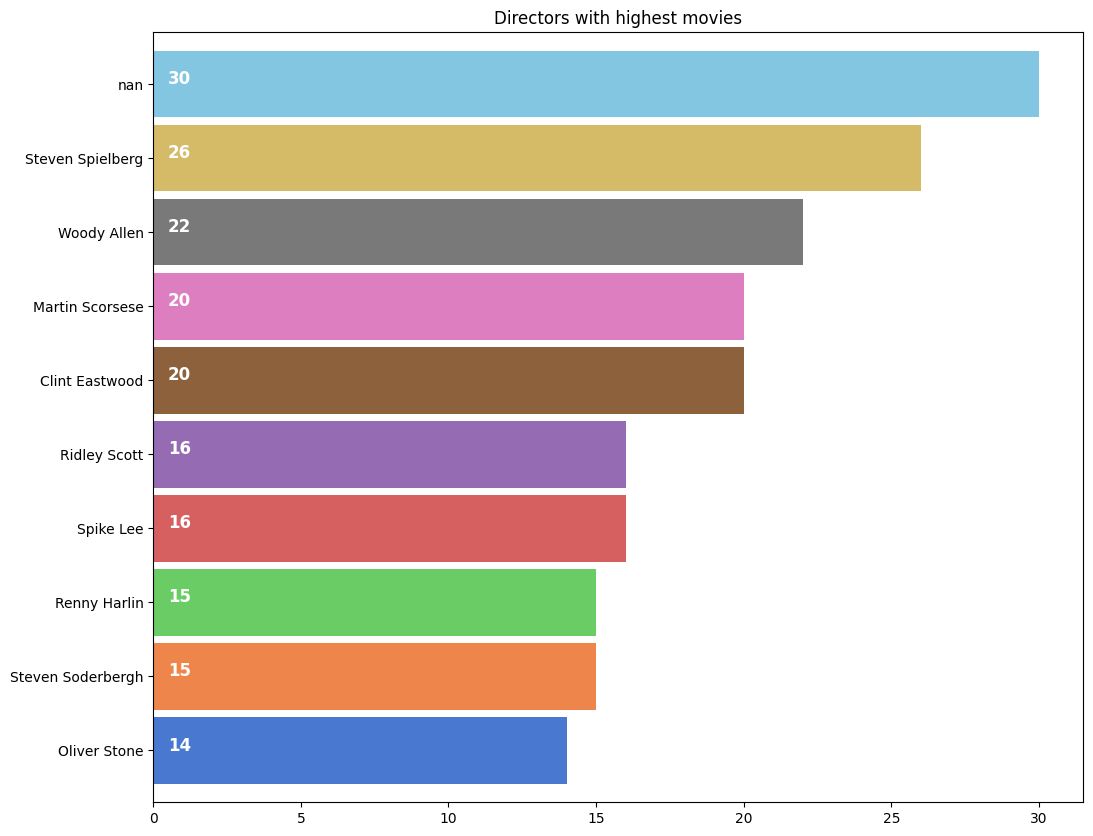

In [19]:
def xstr(s):
    if s is None:
        return ''
    return str(s)
movies['director'] = movies['director'].apply(xstr)
plt.subplots(figsize=(12,10))
ax = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()


We create a new column ‘director_bin’ as we have done earlier



In [20]:
directorList=[]
for i in movies['director']:
    if i not in directorList:
        directorList.append(i)
movies['director_bin'] = movies['director'].apply(lambda x: binary(x, directorList))
movies.head()


,id,original_title,genres,cast,vote_average,keywords,director,genres_bin,cast_bin,director_bin
0,19995,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]","SamWorthington,SigourneyWeaver,StephenLang,Zoe...",7.2,"['culture clash', 'future', 'space war', 'spac...",James Cameron,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","JohnnyDepp,KeiraKnightley,OrlandoBloom,Stellan...",6.9,"['ocean', 'drug abuse', 'exotic island', 'east...",Gore Verbinski,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,206647,Spectre,"[Action, Adventure, Crime]","ChristophWaltz,DanielCraig,LéaSeydoux,RalphFie...",6.3,"['spy', 'based on novel', 'secret agent', 'seq...",Sam Mendes,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","AnneHathaway,ChristianBale,GaryOldman,MichaelC...",7.6,"['dc comics', 'crime fighter', 'terrorist', 's...",Christopher Nolan,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,49529,John Carter,"[Action, Adventure, ScienceFiction]","LynnCollins,SamanthaMorton,TaylorKitsch,Willem...",6.1,"['based on novel', 'mars', 'medallion', 'space...",Andrew Stanton,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Working with the Keywords column

In [21]:
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')')

 We find ‘words_bin’ from Keywords as follows 

In [22]:
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')
words_list = []
for index, row in movies.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)
movies['words_bin'] = movies['keywords'].apply(lambda x: binary(x, words_list))
movies = movies[(movies['vote_average']!=0)]  #removing the movies with 0 score and without drector names 
movies = movies[movies['director']!='']




Similarity between movies

In [23]:
def Similarity(movieId1, movieId2):
     a = movies.iloc[movieId1]
     b = movies.iloc[movieId2]
     
     genresA = a['genres_bin']
     genresB = b['genres_bin']
     
     genreDistance = spatial.distance.cosine(genresA, genresB)
     scoreA = a['cast_bin']
     scoreB = b['cast_bin']
     scoreDistance = spatial.distance.cosine(scoreA, scoreB)

     directA = a['director_bin']
     directB = b['director_bin']
     directDistance = spatial.distance.cosine(directA, directB)

     wordsA = a['words_bin']
     wordsB = b['words_bin']
     wordsDistance = spatial.distance.cosine(wordsA, wordsB)
     return genreDistance + directDistance + scoreDistance + wordsDistance
 



In [24]:
Similarity(3, 1000)
# print(movies.iloc[3])
# print(movies.iloc[160])

3.05

In [25]:
def predict_score():
    name = input('Enter a movie title: ')
    new_movie = movies[movies['original_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.original_title.values[0])

    def getNeighbors(baseMovie, K):
        distances = []
        for index, movie in movies.iterrows():
            if (index != int(baseMovie.index.values[0]) and index < movies.__len__()):
                dist = Similarity(int(baseMovie.index.values[0]), index)
                distances.append((index, dist))
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors
    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)
    print('\nRecommended Movies: \n')
    for neighbor in neighbors:
        avgRating = avgRating+ int(movies.iloc[neighbor[0]]['vote_average'])
        print( movies.iloc[neighbor[0]]['original_title']+" | Genres: "+str(movies.iloc[neighbor[0]]['genres']).strip('[]').replace(' ','')+" | Rating: "+str(movies.iloc[neighbor[0]]['vote_average']))
    print('\n')
    avgRating = avgRating/K
    print('The predicted rating for %s is: %f' %(new_movie['original_title'].values[0],avgRating))
    print('The actual rating for %s is %f' %(new_movie['original_title'].values[0],new_movie['vote_average']))


In [28]:
predict_score()

Selected Movie:  The Martian

Recommended Movies: 

Exodus: Gods and Kings | Genres: 'Adventure','Drama','Action' | Rating: 5.6
Prometheus | Genres: 'ScienceFiction','Adventure','Mystery' | Rating: 6.3
Gladiator | Genres: 'Action','Drama','Adventure' | Rating: 7.9
Blade Runner | Genres: 'ScienceFiction','Drama','Thriller' | Rating: 7.9
Kingdom of Heaven | Genres: 'Drama','Action','Adventure','History','War' | Rating: 6.6
White Squall | Genres: 'Action','Drama' | Rating: 6.3
Body of Lies | Genres: 'Action','Drama','Thriller' | Rating: 6.5
Alien | Genres: 'Horror','Action','Thriller','ScienceFiction' | Rating: 7.9
Robin Hood | Genres: 'Action','Adventure' | Rating: 6.2
American Gangster | Genres: 'Drama','Crime' | Rating: 7.4


The predicted rating for The Martian is: 6.300000
The actual rating for The Martian is 7.600000
